Bonus: Recommender system using similarity measures

Item KNN cosine

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Reading the data into pandas df
data = pd.read_csv('u.data', header = None, delimiter = '\t')
colsData = ['userId','itemId','rating','timestamp']
data.columns = colsData
#print(data)

item = pd.read_csv('u.item', header = None, delimiter = '|',encoding='latin-1')
colsItem = ['itemId','movieTitle','releaseDate','videoReleaseDate','imdbUrl','unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
item.columns = colsItem
#print(item.head())

user = pd.read_csv('u.user', header = None, delimiter = '|',encoding='latin-1')
colsUser = ['userId','age','gender','occupation','zipCode']
user.columns = colsUser
#print(user.head())

In [2]:
#Sampling data
dataNew = pd.DataFrame(data.sample(2000,random_state = 123))
#print(dataNew.shape)

#Joining Item data with base data
Item = pd.merge(dataNew,item,on = 'itemId',how = 'inner')
print("Item Data\n\n",Item.columns.values)

Item Data

 ['userId' 'itemId' 'rating' 'timestamp' 'movieTitle' 'releaseDate'
 'videoReleaseDate' 'imdbUrl' 'unknown' 'Action' 'Adventure' 'Animation'
 'Childrens' 'Comedy' 'Crime' 'Documentary' 'Drama' 'Fantasy' 'Film-Noir'
 'Horror' 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']


In [3]:
#Checking for null values
print("NA's present in Item : ",Item.isnull().any().any())

#Removing columns with less relevance, reducing computing cost
Item = Item.drop(['userId', 'itemId','movieTitle','releaseDate','videoReleaseDate','imdbUrl','timestamp'],axis = 1)

print("NA's present in Item after dropping extra columns : ",Item.isnull().any().any())

Item['rating'] = pd.to_numeric(Item['rating'])

NA's present in Item :  True
NA's present in Item after dropping extra columns :  False


In [4]:
#Seperating into x and y data
from sklearn.model_selection import train_test_split

x = Item.loc[:,Item.columns != 'rating']
y = Item.loc[:,Item.columns == 'rating']

itemXTrain, itemXTest, itemYTrain, itemYTest = train_test_split(x, y, test_size=0.30, random_state=1)

In [5]:
#Cosine distance
def distance(xTrain,yTrain,xTest):
    dist,Class = [],[]
    for i in range(len(xTrain)):
        x = np.array(xTrain.iloc[i])
        y = np.array(yTrain.iloc[i])
        #print("x,y",x,xTest)
        pdt = x.dot(xTest)
        mag1 = np.sqrt((x**2).sum())
        mag2 = np.sqrt((xTest**2).sum())
        similarity = pdt/(mag1*mag2)
        #print("dist",similarity,pdt,mag1,mag2)
        dist.append(similarity)
        Class.append(float(y))
    result = pd.DataFrame({'dist': dist,'rating':Class})
    return(result)

In [6]:
#K Nearest Neighbors
def nearestNeighbor(xTrain,yTrain,xTest,k):
    predicted = []
    for i in range(len(xTest)):
        xNew = np.array(xTest.iloc[i])
        dis = distance(xTrain,yTrain,xNew)
        dis = dis.sort_values(by='dist', ascending=0)
        #print(dis)
        #Getting values for k nearest neighbors
        knn = dis[:k]
        #Predicting the values
        rate = knn['rating'].mean()
        classPredicted = (knn['rating'].value_counts()).sort_values(ascending=False)
        predicted.append(float(classPredicted.idxmax()))
    return(predicted)

In [7]:
#RMSE calculation
def accuracy(predicted,yTest):
    error = (predicted-yTest)**2
    rmse = np.sqrt(error.sum())/len(predicted)
    return(float(rmse))

In [64]:
#defining grid values for k
kGrid = np.arange(31,80,2)
print(kGrid)

[31 33 35 37 39 41 43 45 47 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79]


In [9]:
#returns the test and train data for each fold of cross validation
def cvTestTrain(trainA,testFold,totalFolds):
    trainCv = pd.DataFrame([])
    testCv = pd.DataFrame([])
    #Extracting column names
    cols = trainA.columns.values
    #Removing colunm names
    trainA.columns = [''] * len(trainA.columns)
    #Data split to folds
    batch = np.array_split(trainA,totalFolds)
    key = 1
    trainDict = {}
    #Creating the test fold
    for each in batch:
        trainDict[key] = each
        key = key + 1
    testCv = trainDict[testFold]
    testCv.columns = cols
    #Creating train fold
    for key in range(1,6):
        if(key != testFold):
            trainCv = trainCv.append(trainDict[key])
    #Adding the column names to merged train datset
    trainCv.columns = cols
    return(trainCv,testCv)

In [10]:
#CrossValidation
def cv(trainCvalid,kGrid,totalFolds):
    k,acc = [],[]
    #For each k value
    for eachK in kGrid:
        k.append(eachK)
        eachFoldAccuracy = []
        #Each fold
        for each in range(1,totalFolds+1):
            print(each)
            trainC = trainCvalid.copy()
            #Data split
            trainCv,testCv = cvTestTrain(trainC,each,totalFolds)
            xTrain = trainCv.loc[:,testCv.columns != 'rating']
            yTrain = trainCv.loc[:,testCv.columns == 'rating']
            xTest = testCv.loc[:,testCv.columns != 'rating']
            yTest = testCv.loc[:,testCv.columns == 'rating']
            #Predicting the value
            predicted = nearestNeighbor(xTrain,yTrain,xTest,eachK)
            accu = accuracy(predicted,yTest['rating'])
            eachFoldAccuracy.append(accu)
        temp = (np.mean(eachFoldAccuracy))
        acc.append(float(temp))
    return(k,acc)

In [22]:
#Concatenating dataset for cv
itemTrain = pd.concat([itemXTrain, itemYTrain], axis=1)
itemTest = pd.concat([itemXTest, itemYTest], axis=1)

#Cv function
k1,rmse1 = cv(itemTrain,kGrid,5) 

In [66]:
#Storing result in a df
result = pd.DataFrame({'k' : kGrid,'rmse' : rmse1})

#Choosing optimal k with least RMSE
optimal = result.iloc[result['rmse'].idxmin()]
kOptimal = optimal['k']

Optimal k :  41.0


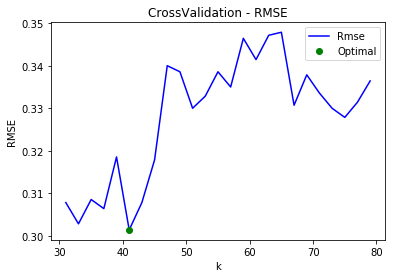

In [67]:
#Plotting the results
plt.plot(result['k'],result['rmse'],color = 'b',label = "Rmse")
plt.plot(optimal['k'],optimal['rmse'],'o',color = 'g',label = "Optimal")
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('CrossValidation - RMSE')
plt.legend()
print("Optimal k : ",optimal['k'])
plt.show()

In [68]:
#Finding RMSE on test set
predicted = nearestNeighbor(itemXTrain,itemYTrain,itemXTest,41)
accu = accuracy(predicted,itemYTest['rating'])
print("RMSE : ",accu)

RMSE :  0.052493385826745405


User KNN

In [13]:
#Sampling data
dataNew = pd.DataFrame(data.sample(2100,random_state = 123))
#print(dataNew.shape)

#Joining User data with base data
User = pd.merge(dataNew,user,on = 'userId',how = 'inner')
#print("\nUser Data\n\n",User.columns.values)
User = User.drop(['userId','itemId','timestamp'],axis =1)

print("NA's present in User : ",User.isnull().any().any())

#Getting index to remove non-numeric zipcodes, as converting to category will increase computational cost tremendously
import re
need,notNeed = [],[]
for each,i in zip(User['zipCode'],range(0,2101)):
    check = each.isnumeric()
    if check == True:
        need.append(i)
    else:
        notNeed.append(i)
        
User = User.drop(User.index[notNeed])
#print(User['zipCode'].unique())

User['zipCode'] = User['zipCode'].astype('float')

col = ['age','gender','occupation']
for each in col:
    User[each] = User[each].astype('category')

#Hot-one encoding
User = pd.get_dummies(User,drop_first = True)

#print("\nUser Data\n\n",User.columns.values)



NA's present in User :  False


In [14]:
#Data x and y split
x = User.loc[:,User.columns != 'rating']
y = User.loc[:,User.columns == 'rating']

userXTrain, userXTest, userYTrain, userYTest = train_test_split(x, y, test_size=0.30, random_state=1)

userXTrain['zipCode'] = (userXTrain['zipCode'] - userXTrain['zipCode'].min())/(userXTrain['zipCode'].max()-userXTrain['zipCode'].min())
userXTest['zipCode'] = (userXTest['zipCode'] - userXTest['zipCode'].min())/(userXTest['zipCode'].max()-userXTest['zipCode'].min())


/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [20]:
#Concatenating for cv
userTrain = pd.concat([userXTrain, userYTrain], axis=1)
userTest = pd.concat([userXTest, userYTest], axis=1)
#cv
k2,rmse2 = cv(userTrain,kGrid,5) 

In [70]:
#Storing result in df
result2 = pd.DataFrame(
    {'k' : kGrid,
     'rmse' : rmse2})

#Choosing optimal k with least RMSE
optimal2 = result2.iloc[result2['rmse'].idxmin()]
kOptimal2 = optimal2['k']

Optimal k :  39.0


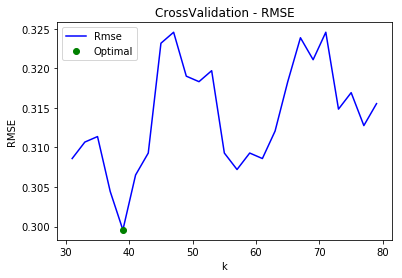

In [71]:
#Plotting results
import matplotlib.pyplot as plt
plt.plot(result2['k'],result2['rmse'],color = 'b',label = "Rmse")
plt.plot(optimal2['k'],optimal2['rmse'],'o',color = 'g',label = "Optimal")
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('CrossValidation - RMSE')
plt.legend()
print("Optimal k : ",optimal2['k'])
plt.show()

In [72]:
#Computing RMSE on test data
predicted = nearestNeighbor(userXTrain,userYTrain,userXTest,39)
accu = accuracy(predicted,userYTest['rating'])
print("RMSE : ",accu)

RMSE :  0.049213396483773236
